In [1]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import sklearn
import sklearn.preprocessing

/home/irmak/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/irmak/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/irmak/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/irmak/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [8]:
class DDPGAgent:    
    def __init__(self, env, state_size=2, goal_size=1, action_size=1, action_low=-1, action_high=1,
                 discount_rate=0.98, polyak=0.95, actor_learning_rate=0.01, critic_learning_rate=0.01,
                 n_epochs=500, n_episodes=50, n_timesteps=500, n_opt_steps=20, batch_size=32, buffer_size=50000):
        
        # initialize variables
        self.env = env
        # dimensions of state, goal and actions
        self.state_size = state_size
        self.goal_size = goal_size
        self.action_size = action_size
        # range of action 
        self.action_low = action_low
        self.action_high = action_high
        # rates
        self.discount_rate = discount_rate # to be used in the bellman equation
        self.actor_learning_rate = actor_learning_rate # learning rate of the policy network
        self.critic_learning_rate = critic_learning_rate # learning rate of the q network
        self.polyak = polyak # to be used in replacement to the target networks
        # number of epochs and episodes(number of replays)
        self.n_epochs = n_epochs
        self.n_episodes = n_episodes
        self.n_timesteps = n_timesteps
        self.n_opt_steps = n_opt_steps # number of optimization steps
        # set the batch and buffer size
        self.batch_size = batch_size # size of the batch in the optimization phase
        self.buffer_size = buffer_size # size of the replay buffer
        self.replay_buffer = [] # initialize the replay buffer

        # initialize neural networks
        self.initialize_networks()
        
        # create a scaler to scale/normalize input states
        state_space_samples = np.array([self.env.observation_space.sample() for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(state_space_samples)
   
    def get_A(self, S, G, scope): # actor network, returns action placeholder
        layer_size = 40
        n_outputs = self.action_size
        
        with tf.variable_scope(scope):
            init_xavier = tf.contrib.layers.xavier_initializer()
            
            x = tf.concat([S,G], 1)
            x = tf.layers.dense(x, layer_size, tf.nn.elu, init_xavier)
            x = tf.layers.dense(x, layer_size, tf.nn.elu, init_xavier)
            
            # variance is also learned by the network
            mu = tf.layers.dense(x, n_outputs, None, init_xavier)
            sigma = tf.layers.dense(x, n_outputs, None, init_xavier)
            sigma = tf.nn.softplus(sigma) + 1e-5
            # get the action placeholder from the normal distribution
            norm_dist = tf.contrib.distributions.Normal(mu, sigma)
            A = tf.squeeze(norm_dist.sample(1), axis=0)
            A = tf.clip_by_value(A, self.action_low, self.action_high)
        
        return A
        
    def get_Q(self, S, A, G, scope): # critic network, returns q value placeholder
        layer_size = 400
        n_outputs = 1
        
        with tf.variable_scope(scope):
            init_xavier = tf.contrib.layers.xavier_initializer()
        
            x = tf.concat([S,A,G], 1)
            x = tf.layers.dense(x, layer_size, tf.nn.elu, init_xavier)
            x = tf.layers.dense(x, layer_size, tf.nn.elu, init_xavier) 
            Q = tf.layers.dense(x, n_outputs, None, init_xavier)
            
        return Q

    # initialize neural networks by using tensorflow
    # actor: calculates action (policy) given state
    # critic: calculates q value given state and action
    # for replacement issues there should be target and evaluated versions of these networks
    # so in total 4 networks are generated
    def initialize_networks(self):
        tf.reset_default_graph()
        self.sess = tf.Session() # session is used to run different networks with different params
        
        # initialize variables to propagate through the network
        self.S = tf.placeholder(tf.float32, [None, self.state_size], 'state')
        self.NS = tf.placeholder(tf.float32, [None, self.state_size], 'next_state')
        self.G = tf.placeholder(tf.float32, [None, self.goal_size], 'goal')
        self.D = tf.placeholder(tf.float32, [None, ], 'done')
        self.R = tf.placeholder(tf.float32, [None, ], 'reward')
        
        # build target and evaluated networks
        with tf.variable_scope("actor"):
            self.A = self.get_A(self.S, self.G, scope="eval")
            self.AT = self.get_A(self.S, self.G, scope="target")
        with tf.variable_scope("critic"):
            self.Q = self.get_Q(self.S, self.A, self.G, scope="eval")
            self.QT = self.get_Q(self.NS, self.AT, self.G, scope="target")
        
        # create parameters
        self.a_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='actor/target')
        self.c_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='critic/target')
            
        # set loss functions and optimizers for the networks
        Y = self.R + self.discount_rate * (1-self.D) * self.QT
        self.actor_loss = -tf.reduce_mean(self.Q)
        self.critic_loss = tf.reduce_mean(tf.squared_difference(self.Q, Y))
        
        self.actor_optimizer = tf.train.AdamOptimizer(
            self.actor_learning_rate, name='actor_optimizer').minimize(self.actor_loss, var_list=self.a_params)
        self.critic_optimizer = tf.train.AdamOptimizer(
            self.critic_learning_rate, name='critic_optimizer').minimize(self.critic_loss, var_list=self.c_params)
        
        # set update operation from the evaluated nets to the target nets
        self.update_target_op = [[tf.assign(atp, self.polyak*atp + (1-self.polyak)*ap), tf.assign(ctp, self.polyak*ctp + (1-self.polyak)*cp)]
                           for ap, atp, cp, ctp in zip(self.a_params, self.at_params, self.c_params, self.ct_params)]
        
        self.sess.run(tf.global_variables_initializer())    
    
    def update_target_network(self):
        self.sess.run(self.update_target_op)

    #function to normalize states
    def scale_state(self, S): #requires input shape=(2,)
        scaled = self.scaler.transform([S])
        return scaled #returns shape =(1,2) 
        
#     # method to train
    def train(self, use_her=True):
        n_rand_goals = 5
        
        mean_reward = []
        success_rate = []
        
        steps = 1
        
        for epoch in range(self.n_epochs):
            successes = 0
            total_reward = 0
            for episode in range(self.n_episodes):
                # sample a goal and initial state
                current_state = env.reset()
                goal = env.goal_position
                episode_reward = 0
                has_reached_goal = False
                
                for t in range(self.n_timesteps):
                    steps += 1
                    
                    # sample an action a_t using the behavioral policy from A
                    action  = self.sess.run(self.A, feed_dict={self.S: self.scale_state(current_state),
                                                               self.G: np.reshape([goal], (1,self.goal_size))})[0]
                    
                    # execute the chosen action and set the reward and done
                    next_state, _, solved, _ = env.step(action)
                    reward = next_state[0] >= goal
                    done = t == self.n_timesteps - 1
                    
                    if solved: has_reached_goal = True
                    episode_reward += reward
                    
                    # store the transition
                    self.replay_buffer.append([current_state, action, reward, next_state, done, goal])
                    if len(self.replay_buffer) >= self.buffer_size: self.replay_buffer.pop(0)
                    
                    # HER - sample additional goals
                    if use_her and steps % 50 == 0 and steps > n_rand_goals:
                        # sample goals
                        sample_goals = np.array(random.sample(self.replay_buffer, n_rand_goals))[:,3]
                        sample_goals = [g[0] for g in sample_goals]
                        
                        for sampled_goal in sample_goals:
                            # calculate reward for each sampled goal
                            sampled_reward = next_state[0] >= sampled_goal
                            # store this transition as well
                            self.replay_buffer.append([current_state, action, sampled_reward, next_state, done, sampled_goal])
                    
                    # have optimization for some set numbers
                    if steps % 100 == 0:
                        
                        for _ in range(self.n_opt_steps):
                            # sample a minibatch from replay buffer
                            minibatch = np.array(random.sample(self.replay_buffer, self.batch_size))
                            
                            # split the data into states, actions, ... 
                            states = np.array([np.squeeze(self.scale_state(s)) for s in minibatch[:,0]])
                            actions = np.vstack(minibatch[:,1])
                            rewards = minibatch[:,2]
                            next_states = np.array([np.squeeze(self.scale_state(ns)) for ns in minibatch[:,3]])
                            dones = minibatch[:,4]
                            goals = np.vstack(minibatch[:,5])
                            
                            # actor training
                            self.sess.run([self.actor_optimizer, self.actor_loss],
                                          feed_dict={self.S: states, self.A: actions, self.G: goals})
                            # critic training
                            self.sess.run([self.critic_optimizer, self.critic_loss],
                                          feed_dict={self.S: states, self.A: actions, self.R: rewards,
                                                     self.NS: next_states, self.D: dones, self.G: goals})
                    

                    # update the state
                    current_state = next_state

                    if done:
                        print('\repoch: {}, episode: {}, episode_reward: {}'.format(epoch, episode, episode_reward), end="")
                        break

                # save the success rate 
                total_reward += episode_reward
                successes += has_reached_goal
                
                # save rewards and success rates for different episodes
                success_rate.append(has_reached_goal)
                mean_reward.append(episode_reward)
            
            # if there were no rewards in the last epoch, restart the fit function
            if epoch == 0 and total_reward == 0:
                self.replay_buffer = []
                print('\n ** restarting fit... ** ')
                return self.train(use_her)
            
            print('\n\repoch: {}, success rate: {}, mean reward: {}'.format(epoch, successes/self.n_episodes,
                                                                            total_reward/self.n_episodes))
            
        return mean_reward, success_rate

#     def train_reward(self, next_state, action, goal):
#         reward = 0
#         if next_state[0] >= goal:
#             reward = 100
#         reward -= math.pow(action[0], 2) * 0.1
        
#         return reward / 100

#     # method to train
#     def train(self, use_her=True):
#         n_rand_goals = 5
        
#         mean_reward = []
#         steps = 1
#         for epoch in range(self.n_epochs):
#             total_reward = 0
            
#             for episode in range(self.n_episodes):
#                 # sample a goal and initial state
#                 current_state = env.reset()
#                 goal = np.array([env.goal_position, env.goal_velocity])
#                 episode_reward = 0
                
#                 done = False
#                 while not done:
#                     steps += 1
                    
#                     # sample an action a_t using the behavioral policy from A
#                     action  = self.sess.run(self.A, feed_dict={self.S: self.scale_state(current_state),
#                                                                self.G: np.reshape(goal, (1,self.goal_size))})[0]
                    
#                     # execute the chosen action and set the reward and done
#                     next_state, env_reward, done, _ = env.step(action)
#                     train_reward = self.train_reward(next_state, action, goal[0])
                    
#                     episode_reward += env_reward
                    
#                     # store the transition
#                     self.replay_buffer.append([current_state, action, train_reward, next_state, done, goal])
#                     if len(self.replay_buffer) >= self.buffer_size: self.replay_buffer.pop(0)
                    
#                     # HER 
#                     if use_her and steps % n_rand_goals == 0 and steps > n_rand_goals:
#                         # sample goals
#                         sample_goals = np.array(random.sample(self.replay_buffer, n_rand_goals))[:,3]
                        
#                         for sampled_goal in sample_goals:
#                             # calculate reward for each sampled goal
#                             sampled_reward = self.train_reward(next_state, action, goal[0])
#                             # store this transition as well
#                             self.replay_buffer.append([current_state, action, sampled_reward, next_state, done, sampled_goal])
                    
#                     # have optimization for some set numbers
#                     if steps % 100 == 0:
                        
#                         for _ in range(self.n_opt_steps):
#                             # sample a minibatch from replay buffer
#                             minibatch = np.array(random.sample(self.replay_buffer, self.batch_size))
                            
#                             # split the data into states, actions, ... 
#                             states = np.array([np.squeeze(self.scale_state(s)) for s in minibatch[:,0]])
#                             actions = np.vstack(minibatch[:,1])
#                             rewards = minibatch[:,2]
#                             next_states = np.array([np.squeeze(self.scale_state(ns)) for ns in minibatch[:,3]])
#                             dones = minibatch[:,4]
#                             goals = np.vstack(minibatch[:,5])
                            
#                             # actor training
#                             self.sess.run([self.actor_optimizer, self.actor_loss],
#                                           feed_dict={self.S: states, self.A: actions, self.G: goals})
#                             # critic training
#                             self.sess.run([self.critic_optimizer, self.critic_loss],
#                                           feed_dict={self.S: states, self.A: actions, self.R: rewards,
#                                                      self.NS: next_states, self.D: dones, self.G: goals})
                    

#                     # update the state
#                     current_state = next_state

#                     if done:
#                         print('\repoch: {}, episode: {}, episode_reward: {}'.format(epoch, episode, episode_reward), end="")
#                         break

#                 # save the success rate 
#                 total_reward += episode_reward
                
#                 # save rewards and success rates for different episodes
#                 mean_reward.append(episode_reward)
            
#             # if there were no rewards in the last epoch, restart the fit function
#             if epoch == 0 and total_reward <= 0:
#                 self.replay_buffer = []
#                 print('\n ** restarting fit... ** ')
#                 return self.train(use_her)
            
#             print('\n\repoch: {} mean reward: {}'.format(epoch, total_reward/self.n_episodes))
            
#         return mean_reward

    def draw_env(self):

        current_state = env.reset()
        goal = env.goal_position
        total_reward = 0
        for t in range(self.n_timesteps):
            self.env.render()
            # sample an action a_t using the behavioral policy from A
            action  = self.sess.run(self.A, feed_dict={self.S: self.scale_state(current_state),
                                                       self.G: np.reshape([goal], (1,self.goal_size))})[0]

            # execute the chosen action and set the reward and done
            next_state, _, solved, _ = env.step(action)
            reward = next_state[0] >= goal
            done = t == self.n_timesteps - 1
            current_state = next_state
            total_reward += reward

            current_state = next_state
            
        print('drawing reward: {}'.format(total_reward))
        self.env.close()
        
#     def draw_env(self):

#         # sample a goal and initial state
#         current_state = env.reset()
#         goal = np.array([env.goal_position, env.goal_velocity])
#         episode_reward = 0

#         done = False
#         while not done:

#             self.env.render()
            
#             # sample an action a_t using the behavioral policy from A
#             action  = self.sess.run(self.A, feed_dict={self.S: self.scale_state(current_state),
#                                                        self.G: np.reshape(goal, (1,self.goal_size))})[0]

#             # execute the chosen action and set the reward and done
#             next_state, env_reward, done, _ = env.step(action)

#             episode_reward += env_reward

#             current_state = next_state
            
#         print('drawing reward: {}'.format(episode_reward))
#         self.env.close()        
        
        

        

In [11]:
env = gym.make("MountainCarContinuous-v0")
agent = DDPGAgent(env, goal_size=1, n_epochs=50, n_episodes=10, batch_size=32, buffer_size=50000,
                  n_opt_steps=2, actor_learning_rate=0.000005, critic_learning_rate=0.00001, polyak=0.90,
                  discount_rate = 0.99, n_timesteps=1000)
agent.draw_env()
mean_reward = agent.train(use_her=True)

/home/irmak/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


drawing reward: 0
epoch: 0, episode: 9, episode_reward: 0
 ** restarting fit... ** 
epoch: 0, episode: 9, episode_reward: 0
 ** restarting fit... ** 
epoch: 0, episode: 9, episode_reward: 014
epoch: 0, success rate: 1.0, mean reward: 54.8
epoch: 1, episode: 9, episode_reward: 071
epoch: 1, success rate: 1.0, mean reward: 142.4
epoch: 2, episode: 9, episode_reward: 391
epoch: 2, success rate: 1.0, mean reward: 286.2
epoch: 3, episode: 9, episode_reward: 494
epoch: 3, success rate: 1.0, mean reward: 279.9
epoch: 4, episode: 9, episode_reward: 543
epoch: 4, success rate: 1.0, mean reward: 482.8
epoch: 5, episode: 9, episode_reward: 635
epoch: 5, success rate: 1.0, mean reward: 527.1
epoch: 6, episode: 9, episode_reward: 736
epoch: 6, success rate: 1.0, mean reward: 637.6
epoch: 7, episode: 9, episode_reward: 628
epoch: 7, success rate: 1.0, mean reward: 595.7
epoch: 8, episode: 9, episode_reward: 660
epoch: 8, success rate: 1.0, mean reward: 643.3
epoch: 9, episode: 9, episode_reward: 779

In [13]:
agent.draw_env()

drawing reward: 751


Text(0, 0.5, 'Mean Reward (#timesteps that reached the goal)')

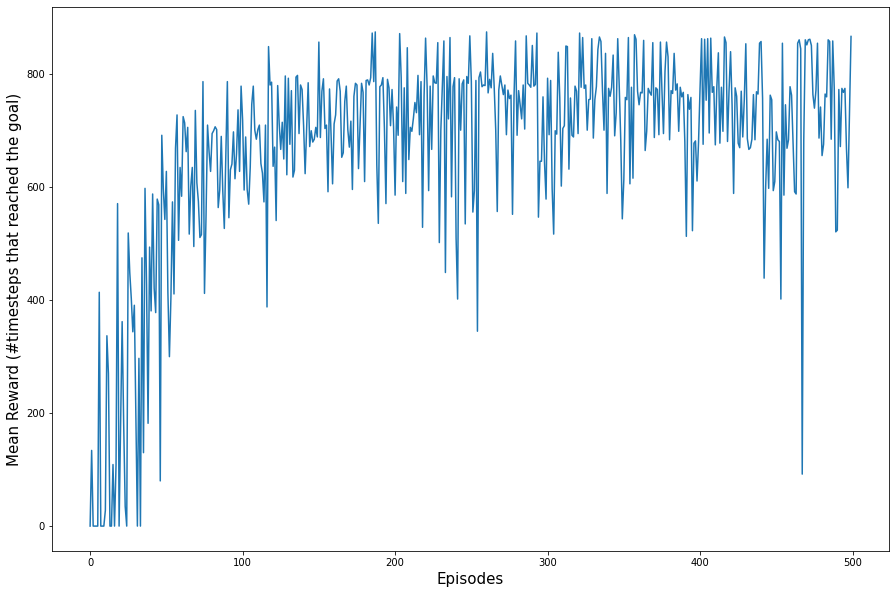

In [27]:
plt.figure(figsize=(15,10))
plt.plot(mean_reward[0])
plt.xlabel("Episodes", fontsize=15)
plt.ylabel("Mean Reward (#timesteps that reached the goal)", fontsize=15)